# Analysis of data and feature engineering - OpenClassrooms Project 4 - Engineer IA

# The financial company **"Ready to Spend"** offers consumer loans to individuals with little or no credit history.

To approve a consumer loan, the company aims to implement a "credit scoring" tool that calculates the probability of a customer repaying it or not, then classifies the request: approved or denied.

The goal is to develop a classification algorithm to assist in deciding whether a loan can be granted to a customer.


#### To speed up data preparation, we use a Kaggle kernel (https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction). However, it is customized to our needs. Specifically, we construct at least three new variables from existing ones that seem relevant to enhance the predictive power of the model. The kernel is fully customized for the project, focusing on creating a Minimum Viable Product (MVP) within the given time constraints. This approach ensures that we can quickly establish a baseline model with sufficient predictive power, which we can then iteratively improve upon. Only application_train will be used in the second part of the project since we use GridSearchCV to optimize the model. The other files will be used in the next part of the project to improve the model.

# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. 

In this notebook, we will stick to using only the main application training and testing data (application_train.csv and application_test.csv) which should be more manageable and contains sufficient features to build a scoring. This will let us establish a baseline that we can then improve upon. We do not merge the data with the other sources in this notebook.

# To Grant Consumer Loans

To grant consumer loans, banks use several relevant variables to assess the risk of customer default. Here is a list of important variables commonly used in banks for this type of financing. We will find these variables in the data provided by Home Credit in the application files which is sufficient to build a credit scoring model for this project. We could improve the model by merging data from other sources, but this will take more time and resources. We will focus on the application files in this note

#### Relevant Variables for Consumer Credit Scoring

**Socio-Demographic Variables:**
- **SK_ID_CURR:** Unique identifier of the client.
- **CODE_GENDER:** Gender of the client.
- **DAYS_BIRTH:** Age of the client in days (negative).
- **NAME_FAMILY_STATUS:** Family status of the client.
- **NAME_HOUSING_TYPE:** Type of housing of the client.


**Financial Variables:**
- **AMT_INCOME_TOTAL:** Total income of the client.
- **AMT_CREDIT:** Amount of credit requested.
- **AMT_ANNUITY:** Credit annuity.
- **AMT_GOODS_PRICE:** Price of goods for which the credit is requested.
- **NAME_INCOME_TYPE:** Type of income of the client.


**Stability Variables:**
- **DAYS_EMPLOYED:** Number of days the client has been employed (negative, 0 if unemployed).
- **DAYS_REGISTRATION:** Number of days since the client's registration.
- **OCCUPATION_TYPE:** Type of employment of the client.

**Behavioral Variables:**
- **CNT_CHILDREN:** Number of dependents of the client.
- **CNT_FAM_MEMBERS:** Number of family members of the client.
- **FLAG_OWN_CAR:** Binary indicator if the client owns a car.
- **FLAG_OWN_REALTY:** Binary indicator if the client owns real estate.

**External Scores:**
- **EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3:** External scores from various sources.

#### Examples of other Ratios and Calculations that could be useful with the data provided

**The relevant business information could be:**
- Amount borrowed / Price of the purchased good: `AMT_CREDIT / AMT_GOODS_PRICE`
- Amount of annuities / Amount borrowed: `AMT_ANNUITY / AMT_CREDIT`
- Amount of annuities / Annual income: `AMT_ANNUITY / AMT_INCOME_TOTAL`
- Employment duration / Age: `DAYS_EMPLOYED / DAYS_BIRTH`
- CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

# Regulatory Requirements in France

**Credit Ceilings:**
Banks must respect maximum credit limits based on the type of credit and the client's profile. These limits are set to ensure that clients do not become over-indebted and to maintain financial stability
To verify this, we use the following variables:

    AMT_CREDIT: Amount of credit requested. This variable ensures that the requested credit amount does not exceed the allowed ceiling for the specific type of credit.

**Repayment Capacity:**
Banks must assess the client's repayment capacity based on their income and expenses. The general rule is that the client's debt-to-income ratio should not exceed 33%, although this can be higher in exceptional cases. Loans should not be granted if the data shows that the client cannot reasonably repay the loan without financial hardship.

- AMT_INCOME_TOTAL: Total income of the client. This variable is used to calculate the debt-to-income ratio.
- AMT_ANNUITY: Credit annuity. Used to determine the monthly payments required to repay the loan.
- CNT_CHILDREN: Number of dependents of the client. This affects household expenses and thus repayment capacity.
- CNT_FAM_MEMBERS: Number of family members of the client. This variable helps estimate total household expenses.
- AMT_GOODS_PRICE: Price of goods for which the credit is requested. Compared to AMT_CREDIT, this can help assess if the loan amount is reasonable relative to the intended purchase.

**Calculating the Debt-to-Income Ratio:**
To ensure that the debt-to-income ratio does not exceed 33%, we use the following formula:

    Debt-to-Income Ratio = (AMT_ANNUITY * 12) / AMT_INCOME_TOTAL

**Conclusion**

We have identified and categorized the relevant variables needed to comply with legal obligations regarding credit ceilings and repayment capacity. These variables are crucial for building a reliable credit scoring model. The good news is that all these variables are available in the application_train.csv file provided by Home Credit (see analysis in the notebook). This ensures that we have sufficient data to assess the risk of customer default accurately and adhere to regulatory requirements and no need to merge data from other sources.








In [128]:
# IF NOT LAUNCHING WITH GOOGLE COLAB, SET THIS TO FALSE
using_colab = False

## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [129]:
import os
import sys

# Detect if the notebook is being run on Google Colab
using_colab = 'google.colab' in sys.modules

if using_colab:
    # connect google drive to colab
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # download packages to google colab
    !pip install numpy
    !pip install pandas
    !pip install sklearn
    !pip install matplotlib
    !pip install seaborn


# to clean output of cell
from IPython.display import clear_output # 
clear_output()

In [130]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore') # used to ignore warnings

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [131]:
import os
import pandas as pd

# Indicate if the script is running on Google Colab or not
using_colab = False  # Change this to True if you are using Colab

# Set the data folder based on the environment
if using_colab:
    data_folder = '/content/gdrive/MyDrive/oc_projet_4/data/'  # Path for Google Colab
else:
    # Get the current working directory as base directory for the notebook
    base_dir = os.getcwd()
    
    # Adjust the data folder path relatively to where the notebook is located
    # Assuming the notebook is inside a 'notebooks' directory and we need to go up one level to access 'data'
    data_folder = os.path.join(base_dir, '..', 'data')

# Define the paths for the data files
train_set = os.path.join(data_folder, 'application_train.csv') # variable that contains the path and the name of the training data file
test_set = os.path.join(data_folder, 'application_test.csv') # variable that contains the path and the name of the testing data file

# Print the path of the training file
print('Training file path:', train_set)

# Load the training data
try:
    app_train = pd.read_csv(train_set) # Load the training data from the file train_set. Train set is variable that contains the path and the name of the training data file
    print('Training data shape: ', app_train.shape)
    display(app_train.head())  # Use display if you are in a notebook, otherwise use print(app_train.head())
except FileNotFoundError as e: # Catch the exception if the file is not found
    print(f"Error: {e}") # Print the error message

Training file path: D:\OC_IA\P4\OC_IA_P4_Build_a_scoring_model\OC_IA_P4_Build_a_scoring_model\notebooks\..\data\application_train.csv
Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
app_train.tail(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307501,456245,0,Cash loans,F,N,Y,3,81000.0,269550.0,11871.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307502,456246,0,Cash loans,F,N,Y,1,94500.0,225000.0,10620.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307503,456247,0,Cash loans,F,N,Y,0,112500.0,345510.0,17770.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
307504,456248,0,Cash loans,F,N,Y,0,153000.0,331920.0,16096.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307505,456249,0,Cash loans,F,N,Y,0,112500.0,225000.0,22050.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [133]:
app_train.info() # Display a concise summary of the training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [134]:
app_train.describe() # Display the summary statistics of the training data

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [135]:
# Testing data features
app_test = pd.read_csv(test_set)
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

The test set is considerably smaller and lacks a `TARGET` column. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [136]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

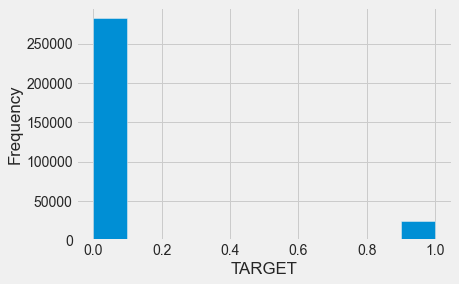

In [137]:
app_train['TARGET'].astype(int).plot.hist();
plt.xlabel('TARGET');

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

## Display the percentage of missing values for each column in the training data

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% Missing
SK_ID_CURR,0,0.000000
TARGET,0,0.000000
NAME_CONTRACT_TYPE,0,0.000000
CODE_GENDER,0,0.000000
FLAG_OWN_CAR,0,0.000000
FLAG_OWN_REALTY,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
AMT_ANNUITY,12,0.003902


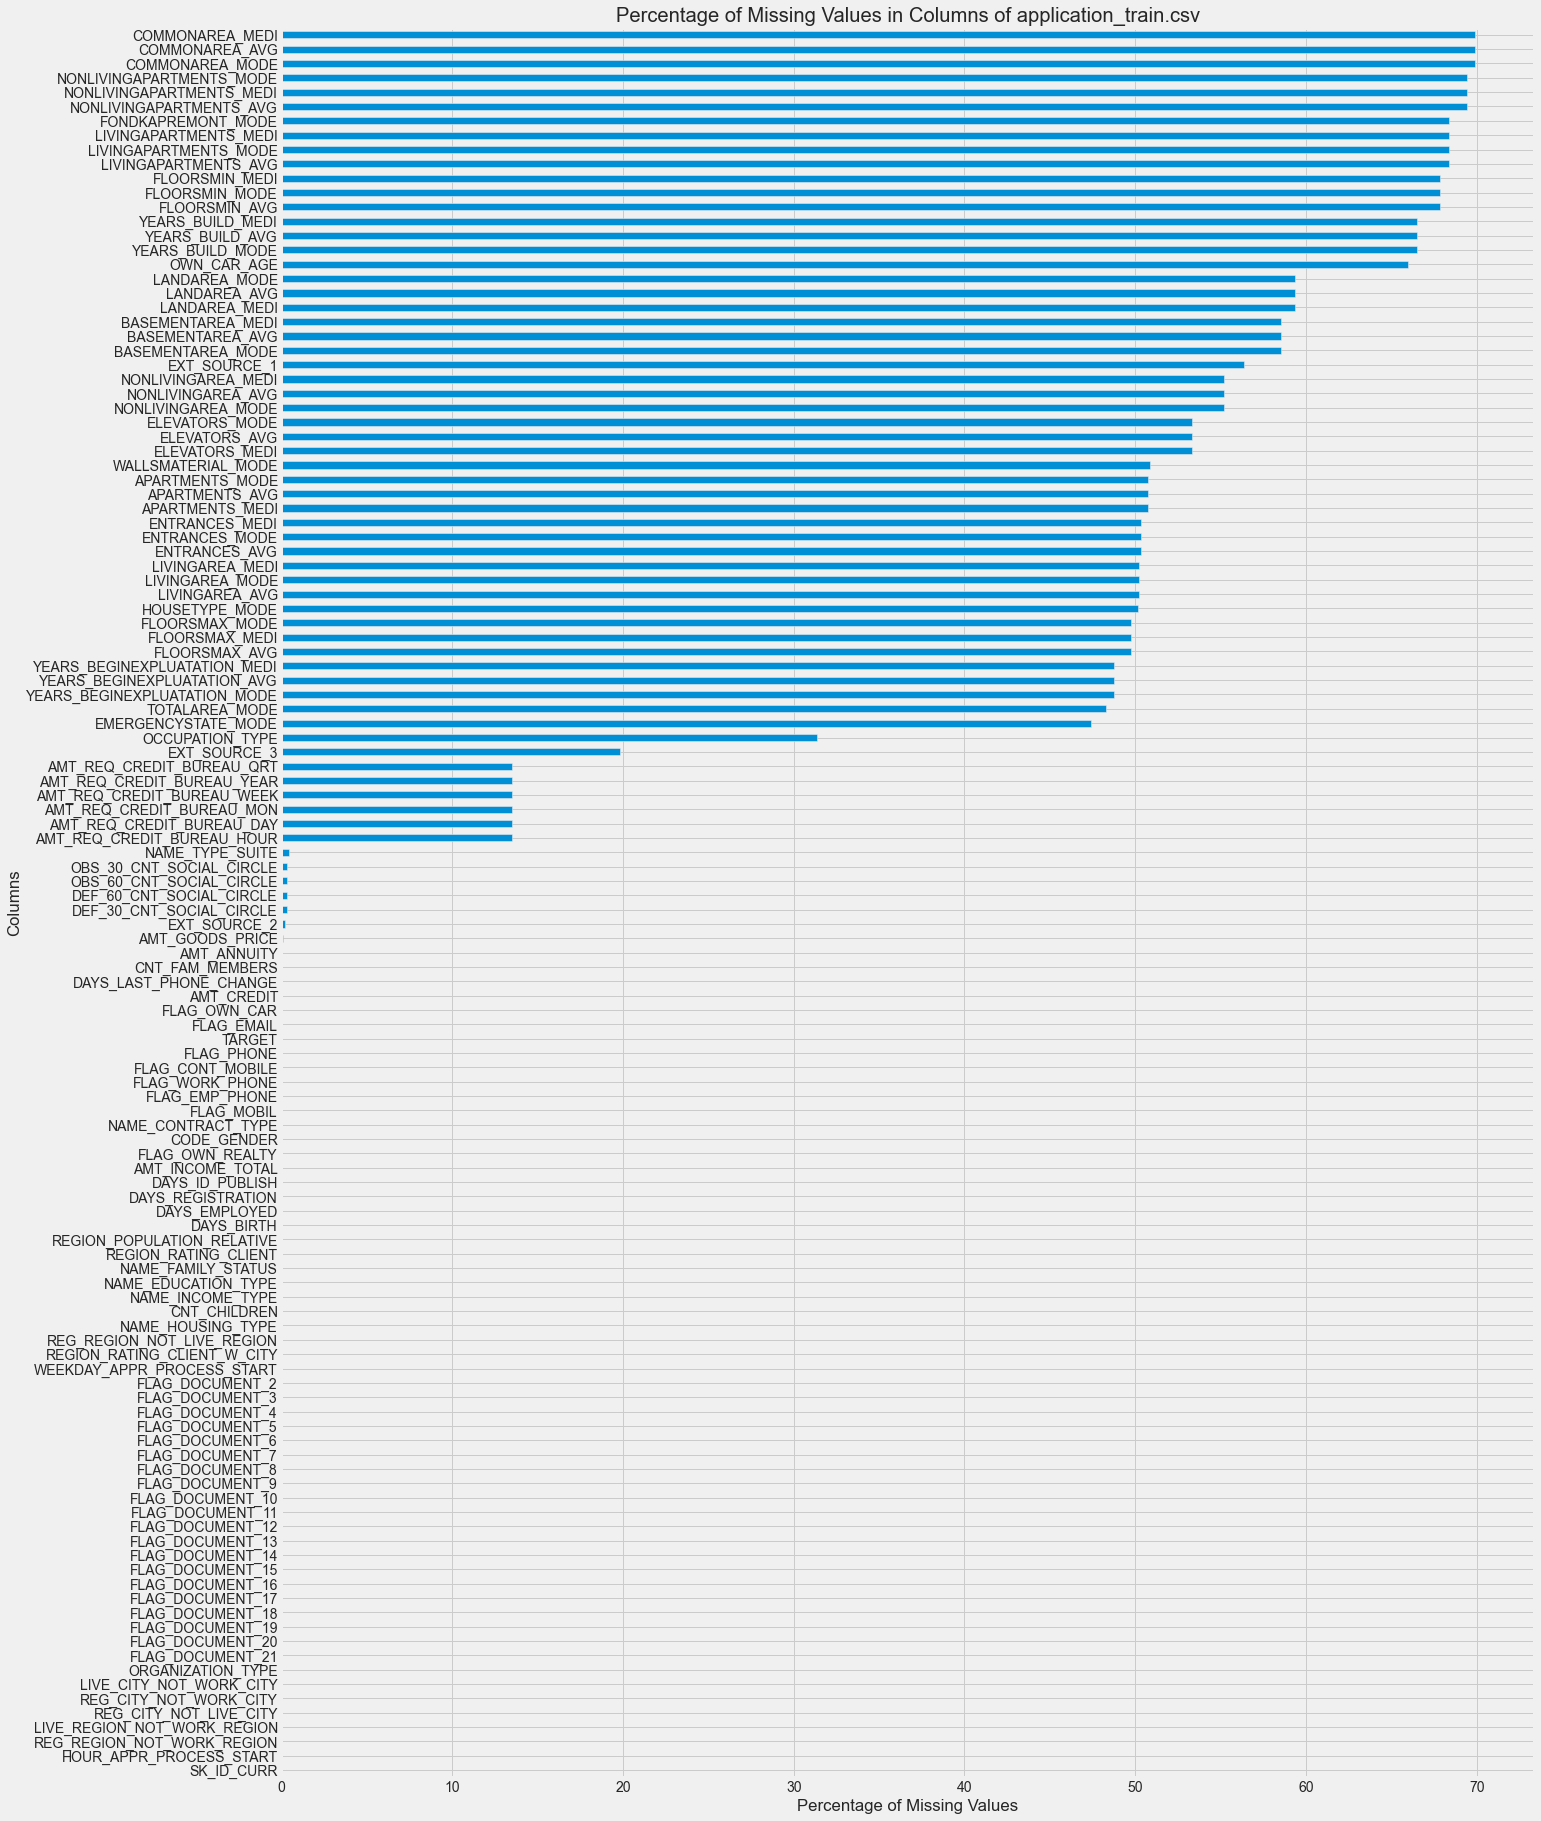

In [138]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% Missing'})
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
           "There are " + str(mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].shape[0]) + 
           " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns, mis_val_percent

# Calculate missing values statistics
missing_values_table_df, mis_val_percent = missing_values_table(app_train)

# Show the first 20 columns with missing values
display(missing_values_table_df.head(20))

# Plot the percentage of missing values
plt.figure(figsize=(20, 30))  # set the figure size
plt.title('Percentage of Missing Values in Columns of application_train.csv')  # set the title of the plot
mis_val_percent.sort_values().plot(kind='barh')  # plot the horizontal bar chart of missing values percentage
plt.xlabel('Percentage of Missing Values')  # set the label for x-axis
plt.ylabel('Columns')  # set the label for y-axis
plt.show()

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [139]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [140]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0) # apply is used to apply a function along an axis of the DataFrame and nunique is used to count the unique elements in the object column

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

In [141]:
# removing duplicate rows
app_train = app_train.drop_duplicates()
print('Duplicates Rows')
print(app_train)

Duplicates Rows
        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y   

In [142]:
# removing duplicate rows
app_train = app_train.drop_duplicates()

In [143]:
app_train.shape

(307511, 122)

## => no duplicates

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us.

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function. get_dummies(df) will only encode the object columns and will return a new dataframe for both the training and testing data.

In [144]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Create a label encoder object
le = LabelEncoder()
le_count = 0  # Initialize the count of label encoded columns
encoded_columns = []  # List to store the names of encoded columns

# Concatenate train and test data to ensure consistent encoding
app_combined = pd.concat([app_train, app_test], axis=0)

# Iterate through the columns
for col in app_combined:
    if app_combined[col].dtype == 'object':  # If a categorical variable
        # If 2 or fewer unique categories
        if len(list(app_combined[col].unique())) <= 2:  # If the number of unique values is less than or equal to 2
            # Train on the combined data
            le.fit(app_combined[col])  # Fit label encoder is used to encode the values of the column
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col].loc[app_train.index])  # Transform the values of the column
            app_test[col] = le.transform(app_test[col].loc[app_test.index])    # Transform the values of the column
            
            # Keep track of how many columns were label encoded
            le_count += 1
            encoded_columns.append(col)  # Add column name to the list
            
print('%d columns were label encoded.' % le_count) # Print the number of columns that were label encoded
print('Encoded columns:', encoded_columns) # Print the names of the columns that were label encoded

# One-hot encoding of categorical variables
app_combined = pd.concat([app_train, app_test], axis=0)

# One-hot encoding
app_combined = pd.get_dummies(app_combined) # Get one hot encoding of the categorical variables

# Split the combined dataframe back into train and test sets
app_train = app_combined.iloc[:app_train.shape[0], :]
app_test = app_combined.iloc[app_train.shape[0]:, :]

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

# Align the training and testing data
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join='inner', axis=1)
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)
print("The difference of 1 column between the DataFrames is due to the 'TARGET' column, which is present in the training DataFrame but not in the testing DataFrame.")


3 columns were label encoded.
Encoded columns: ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 243)
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 243)
The difference of 1 column between the DataFrames is due to the 'TARGET' column, which is present in the training DataFrame but not in the testing DataFrame.


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [145]:
train_labels = app_train['TARGET']  # Allows us to keep the target column in the training data "train_labels" to use it later. Data Integrity. The train_labels variable maintains the exact order of target values corresponding to the rows in app_train.

# Align the training and testing data, keep only columns present in both dataframes that is the intersection of the columns and suppress the columns that are not in the intersection. The row indices remain unchanged and are preserved. No rows are dropped; only columns not present in both DataFrames are removed.
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# Add the target back in the training data kept earlier and to keep the target column in the training data after the aligning. The 'TARGET' column is reattached to app_train using the saved train_labels, ensuring each row in app_train has the correct target value.
app_train['TARGET'] = train_labels

# Calculate the percentage of training and testing data
train_size = app_train.shape[0]
test_size = app_test.shape[0]
total_size = train_size + test_size

train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)
print(f"Training data: {train_size} samples ({train_percentage:.2f}%)")
print(f"Testing data: {test_size} samples ({test_percentage:.2f}%)")

# Explain why there is a difference of one column
print("The difference of 1 column between the DataFrames is due to the 'TARGET' column, which is present in the training DataFrame but not in the testing DataFrame.")


Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 243)
Training data: 307511 samples (86.32%)
Testing data: 48744 samples (13.68%)
The difference of 1 column between the DataFrames is due to the 'TARGET' column, which is present in the training DataFrame but not in the testing DataFrame.


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [146]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [147]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

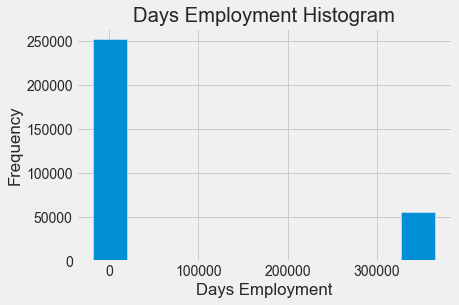

In [148]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [149]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243] # Select all the anomalies
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243] # Select all the non-anomalies
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean())) # Print the percentage of non-anomalies who default
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean())) # Print the percentage of anomalies who default
print('There are %d anomalous days of employment' % len(anom)) # Print the number of anomalous days of employment

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [150]:
# Verify that all anomalies have the same value
anom_value = 365243
if app_train[app_train['DAYS_EMPLOYED'] == anom_value].shape[0] == app_train[app_train['DAYS_EMPLOYED'] == anom_value]['DAYS_EMPLOYED'].count():
    print(f"All anomalies have the value {anom_value} in 'DAYS_EMPLOYED'.")


All anomalies have the value 365243 in 'DAYS_EMPLOYED'.


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



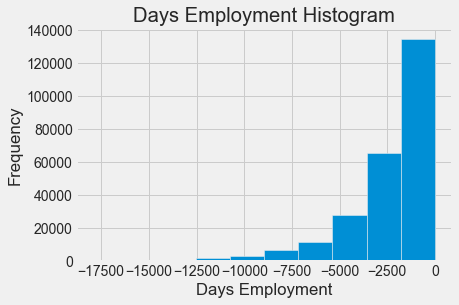

In [151]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243 # Create a new column indicating if the days employed was anomalous with a flag of True or False

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) 

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram'); # Plot a histogram of the days of employment
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (because we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data.

In [152]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243 # Create a new column indicating if the days employed was anomalous
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True) # Replace the anomalous values with nan

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test))) # Print the number of anomalies

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [153]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [154]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH']) # abs is used to return the day birth which actually negative in the dataset
app_train['DAYS_BIRTH'].corr(app_train['TARGET']) # corr is used to calculate the correlation between the two columns

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often (do remember that target = 1 means default customer).

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

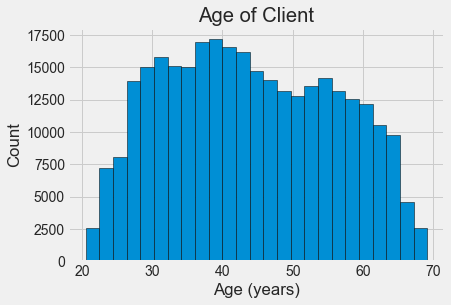

In [155]:
# Set the style of plots
plt.style.use('fivethirtyeight') 

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25) # edgecolor is used to set the color of the edges of the bars, bins is used to set the number of bins
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

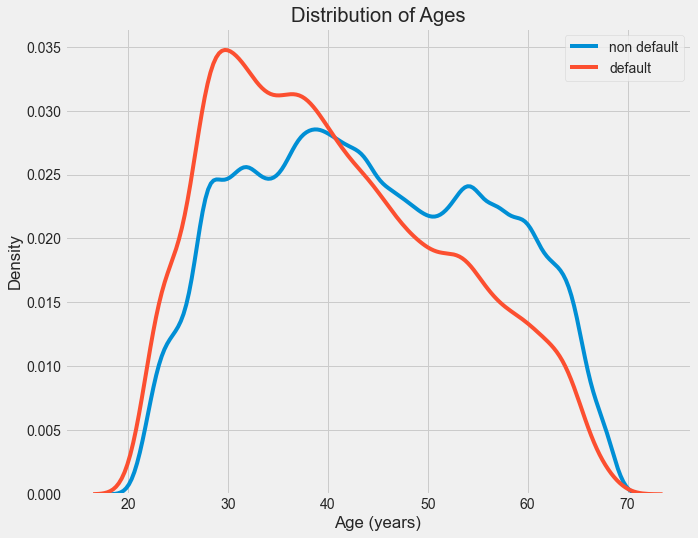

In [156]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time (non-default)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='non default')

# KDE plot of loans which were not repaid on time (default)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='default')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()  # Add legend to distinguish the plots
plt.show()

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [157]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data; bins means the range of the age
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11)) # cut is used to segment and sort data values into bins; linspace is used to return evenly spaced numbers over a specified interval
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,9461,25.920548,"(25.0, 30.0]"
1,0.0,16765,45.931507,"(45.0, 50.0]"
2,0.0,19046,52.180822,"(50.0, 55.0]"
3,0.0,19005,52.068493,"(50.0, 55.0]"
4,0.0,19932,54.608219,"(50.0, 55.0]"
5,0.0,16941,46.413699,"(45.0, 50.0]"
6,0.0,13778,37.747945,"(35.0, 40.0]"
7,0.0,18850,51.643836,"(50.0, 55.0]"
8,0.0,20099,55.065753,"(55.0, 60.0]"
9,0.0,14469,39.641096,"(35.0, 40.0]"


In [158]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


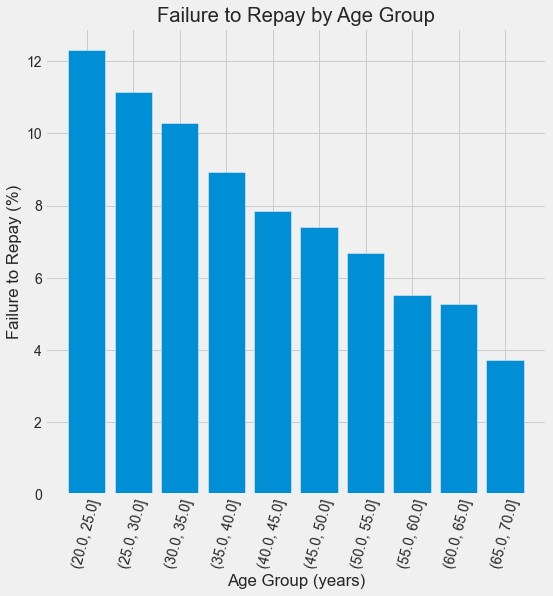

In [159]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET']) # index is used to get the index labels of the DataFrame, astype is used to change the data type of the index labels

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [160]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


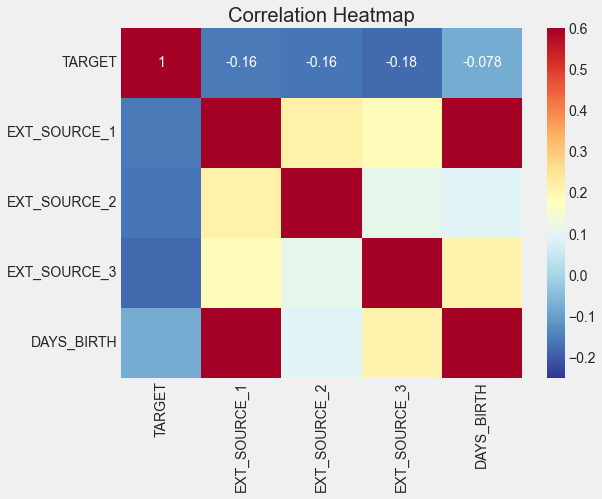

In [161]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

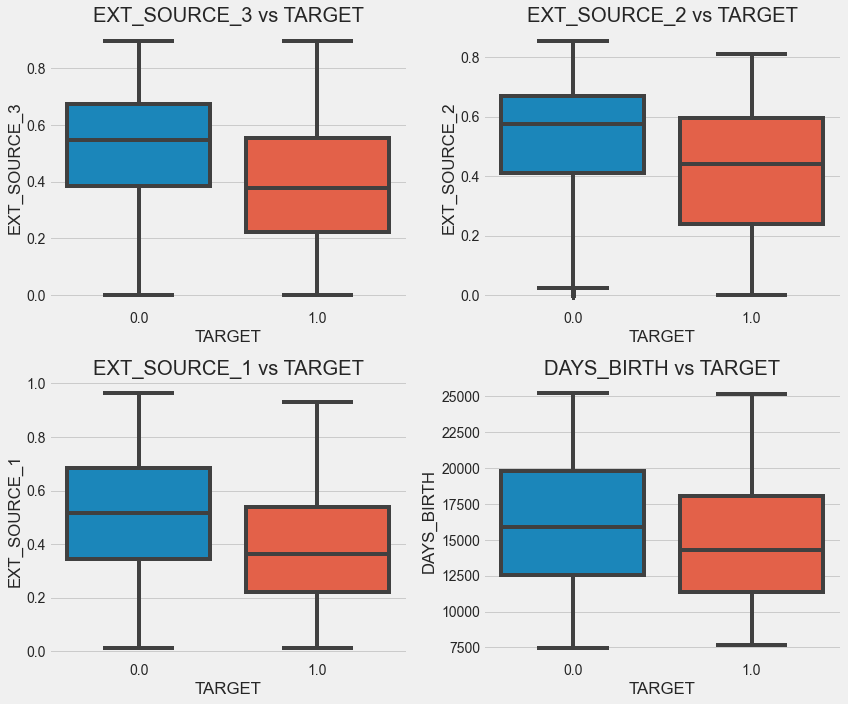

In [162]:
# Box plot of the EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1, DAYS_BIRTH, and the TARGET
plt.figure(figsize=(12, 10))

# Subplot is used to create multiple plots in the same figure
# Subplot 1
plt.subplot(2, 2, 1)
sns.boxplot(x='TARGET', y='EXT_SOURCE_3', data=app_train) # boxplot is used to show the distribution of the data
plt.title('EXT_SOURCE_3 vs TARGET')

# Subplot 2
plt.subplot(2, 2, 2)
sns.boxplot(x='TARGET', y='EXT_SOURCE_2', data=app_train)
plt.title('EXT_SOURCE_2 vs TARGET')

# Subplot 3
plt.subplot(2, 2, 3)
sns.boxplot(x='TARGET', y='EXT_SOURCE_1', data=app_train)
plt.title('EXT_SOURCE_1 vs TARGET')

# Subplot 4
plt.subplot(2, 2, 4)
sns.boxplot(x='TARGET', y='DAYS_BIRTH', data=app_train)
plt.title('DAYS_BIRTH vs TARGET')

# Adjust layout
plt.tight_layout()
plt.show()




### Analysis of Boxplots (EXT_SOURCE and DAYS_BIRTH vs TARGET)

1. **EXT_SOURCE_3**:
   - **Score Distribution**:
     - Individuals with a TARGET of 0 have a higher median EXT_SOURCE_3 than those with a TARGET of 1.
     - The distribution is more spread out for TARGET = 0, indicating greater variability in EXT_SOURCE_3 scores for this category.
   - **Interpretation**:
     - Higher EXT_SOURCE_3 scores seem to be associated with a TARGET of 0, suggesting perhaps better creditworthiness for these individuals.

2. **EXT_SOURCE_2**:
   - **Score Distribution**:
     - The median EXT_SOURCE_2 is also higher for individuals with a TARGET of 0.
     - The variability in scores is greater for TARGET = 0 than for TARGET = 1.
   - **Interpretation**:
     - Similar to EXT_SOURCE_3, higher EXT_SOURCE_2 scores are associated with a TARGET of 0. This might indicate that higher EXT_SOURCE_2 scores are also positive indicators of creditworthiness.

3. **EXT_SOURCE_1**:
   - **Score Distribution**:
     - The median EXT_SOURCE_1 is higher for TARGET = 0.
     - The distribution of values for TARGET = 1 is more restricted and has fewer outliers compared to TARGET = 0.
   - **Interpretation**:
     - Once again, higher EXT_SOURCE_1 scores are associated with a TARGET of 0. This follows the same trend observed for EXT_SOURCE_2 and EXT_SOURCE_3.

4. **DAYS_BIRTH**:
   - **Score Distribution**:
     - Individuals with a TARGET of 0 have a higher median DAYS_BIRTH than those with a TARGET of 1.
     - The distribution is slightly more spread out for TARGET = 0, indicating greater variability in DAYS_BIRTH scores for this category.
   - **Interpretation**:
     - Higher DAYS_BIRTH values (which correspond to older ages, since DAYS_BIRTH is the number of days since birth) seem to be associated with a TARGET of 0. This might suggest that older individuals are less likely to have a TARGET of 1.

### Conclusions and Insights

- **General Trend**:
  - For all three external sources (EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1), higher scores are consistently associated with a TARGET of 0.
  - For DAYS_BIRTH, higher values (indicating older ages) are also associated with a TARGET of 0.
  - This suggests that these variables could be important indicators for predicting or classifying the TARGET, with higher scores and older ages possibly correlating to better creditworthiness.

- **Variability and Outliers**:
  - The distribution of scores for TARGET = 0 is more spread out for EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1, and DAYS_BIRTH, indicating greater variability among these individuals.
  - TARGET = 1 shows a more concentrated distribution, which might signify greater homogeneity in this category.

### Business Conclusion: Best Source for Prediction

Given the analysis, we can derive the following business conclusions regarding the best source for credit scoring predictions:

- **EXT_SOURCE_3** appears to be the most robust indicator, as it shows the greatest difference in median scores between TARGET = 0 and TARGET = 1 and has a broader distribution for TARGET = 0. This suggests that EXT_SOURCE_3 is highly effective at distinguishing between good and bad credit risks.
- **EXT_SOURCE_2** also shows a significant difference in median scores and high variability for TARGET = 0, making it another strong predictor for credit scoring.
- **EXT_SOURCE_1** follows the same trend but with slightly less variability compared to EXT_SOURCE_3 and EXT_SOURCE_2. It is still a valuable predictor, but perhaps not as strong as the other two sources.
- **DAYS_BIRTH** indicates that older individuals tend to have a TARGET of 0, suggesting that age might also be a useful predictor. However, it might be more effective as a supplementary variable rather than a primary indicator.

**Recommendation**:
For the best prediction model, it is recommended to prioritize EXT_SOURCE_3 and EXT_SOURCE_2, as they provide the most significant insights into creditworthiness. EXT_SOURCE_1 should also be included, as it complements the predictive power of the other two sources. DAYS_BIRTH can be considered as an additional feature to enhance the model's accuracy.


### Pair plot for visualization relationship between Relevant Variables for Consumer Credit Scoring

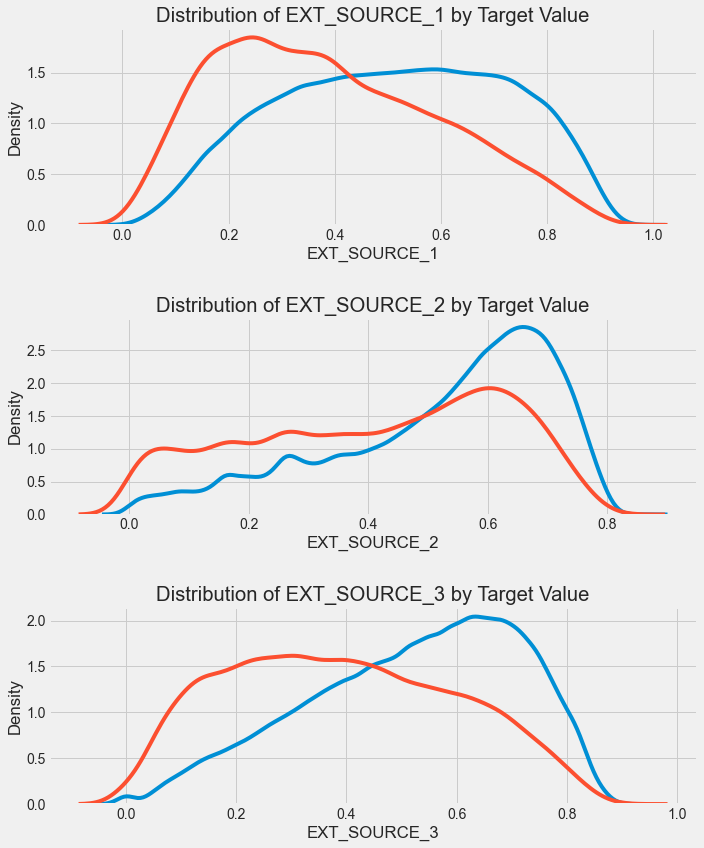

In [165]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

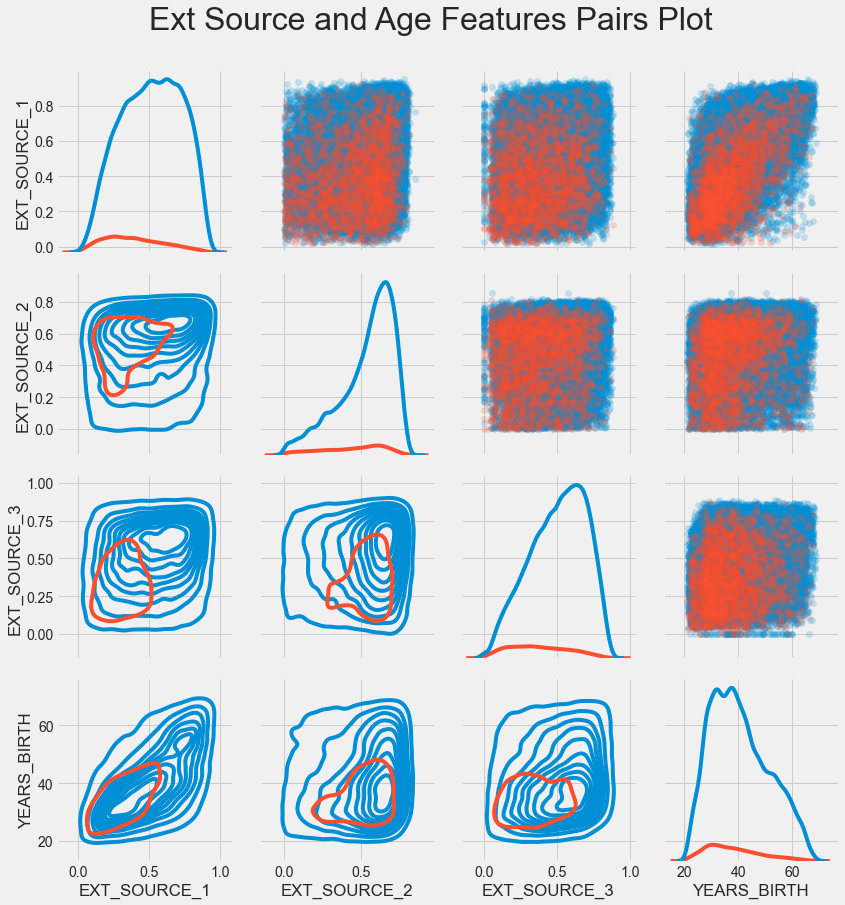

In [166]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. [This is a great article on the subject)](https://www.featurelabs.com/blog/secret-to-data-science-success/). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering." 

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some [automated tools](https://docs.featuretools.com/getting_started/install.html) to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge features


## Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on. These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. In other words, while two variables by themselves  may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. [Interaction terms are commonly used in statistical models](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. 

Jake VanderPlas writes about [polynomial features in his excellent book Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) for those who want more information.

In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. [Scikit-Learn has a useful class called `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into [problems with overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)). 

In [167]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']] # Create a new dataframe from app_train with the columns of interest
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']] # Create a new dataframe from app_test with the columns of interest

# imputer for handling missing values
'''
# deprecated:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
'''
from sklearn.impute import SimpleImputer # SimpleImputer is used to impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median') # Impute missing values using the median along the columns

# Extract and Drop the Target Variable
poly_target = poly_features['TARGET'] # poly_target is used to store the target variable from poly_features 

poly_features = poly_features.drop(columns = ['TARGET']) # poly_features is used to removes the "TARGET" column to ensure that only features are used for generating polynomial features

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features) # Impute the missing values by using the median along the columns; fit_transform is used to fit to data, then transform it
poly_features_test = imputer.transform(poly_features_test) # Impute the missing values by using the median along the columns; transform is used to transform the data

from sklearn.preprocessing import PolynomialFeatures # PolynomialFeatures is used to generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3) # degree is used to set the degree of the polynomial features, can be any non-negative integer, 3 is used because we want to create polynomial features with degree 3

In [168]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [169]:
# Display the shape of the polynomial features
print('Polynomial Features shape: ', poly_features.shape)

# Get the names of the polynomial features
feature_names = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

# Display the names of the polynomial features as a list
print('Polynomial Features names:', list(feature_names))

Polynomial Features shape:  (307511, 35)
Polynomial Features names: ['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_3^2', 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH', 'EXT_SOURCE_2 EXT_SOURCE_3^2', 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIRTH^2', 'DAYS_BIRTH^3']


### Interpretation of the Results

The output provides information about the shape and names of the polynomial features generated from the original features in your dataset. Let's break it down step-by-step for a clear understanding:

1. **Shape of Polynomial Features**:
   - **`Polynomial Features shape: (307511, 35)`**: 
     - This indicates that after applying the polynomial transformation, the dataset now contains 307,511 samples (rows) and 35 features (columns). 
     - Originally, you had 4 features (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`, and `DAYS_BIRTH`). The polynomial transformation of degree 3 has expanded these features to 35 new features, capturing various polynomial terms and interactions.

2. **Names of Polynomial Features**:
   - **`Polynomial Features names:`**:
     - The list provided shows all 35 polynomial features that have been created. Here’s a simplified interpretation of these names:
       - **`'1'`**: This is the bias term, which is always 1. It is used in linear models to account for the intercept.
       - **`Original Features`**: These are the original features without any transformation:
         - `'EXT_SOURCE_1'`
         - `'EXT_SOURCE_2'`
         - `'EXT_SOURCE_3'`
         - `'DAYS_BIRTH'`
       - **`Quadratic Terms`**: These include the square of each original feature and the interaction between every pair of original features:
         - `'EXT_SOURCE_1^2'`, `'EXT_SOURCE_2^2'`, `'EXT_SOURCE_3^2'`, `'DAYS_BIRTH^2'`
         - `'EXT_SOURCE_1 EXT_SOURCE_2'`, `'EXT_SOURCE_1 EXT_SOURCE_3'`, `'EXT_SOURCE_1 DAYS_BIRTH'`
         - `'EXT_SOURCE_2 EXT_SOURCE_3'`, `'EXT_SOURCE_2 DAYS_BIRTH'`
         - `'EXT_SOURCE_3 DAYS_BIRTH'`
       - **`Cubic Terms`**: These include the cube of each original feature and interactions up to the third degree:
         - `'EXT_SOURCE_1^3'`, `'EXT_SOURCE_2^3'`, `'EXT_SOURCE_3^3'`, `'DAYS_BIRTH^3'`
         - `'EXT_SOURCE_1^2 EXT_SOURCE_2'`, `'EXT_SOURCE_1^2 EXT_SOURCE_3'`, `'EXT_SOURCE_1^2 DAYS_BIRTH'`
         - `'EXT_SOURCE_1 EXT_SOURCE_2^2'`, `'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3'`, `'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH'`
         - `'EXT_SOURCE_1 EXT_SOURCE_3^2'`, `'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH'`, `'EXT_SOURCE_1 DAYS_BIRTH^2'`
         - `'EXT_SOURCE_2^2 EXT_SOURCE_3'`, `'EXT_SOURCE_2^2 DAYS_BIRTH'`, `'EXT_SOURCE_2 EXT_SOURCE_3^2'`, `'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH'`
         - `'EXT_SOURCE_2 DAYS_BIRTH^2'`, `'EXT_SOURCE_3^2 DAYS_BIRTH'`, `'EXT_SOURCE_3 DAYS_BIRTH^2'`

### Summary

The transformation has expanded the original 4 features into 35 polynomial features, including:
- Original features
- Quadratic terms (squares and pairwise interactions)
- Cubic terms (cubes and higher-degree interactions)

This expansion helps the model to capture more complex relationships and interactions between the features, potentially improving its predictive power. However, it also increases the complexity of the model, so it's important to monitor for overfitting and consider regularization techniques if necessary.

This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [170]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [171]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, # Create a DataFrame from the polynomial features
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2',  # Get feature names
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH'])) # Specify the feature names

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [172]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left') # Merge the polynomial features into the training dataframe with a left join that is based on the 'SK_ID_CURR' column

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR'] # Add the 'SK_ID_CURR' column to the testing dataframe
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left') # Merge the polynomial features into the testing dataframe with a left join that is based on the 'SK_ID_CURR' column

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1) # Align the training and testing dataframes by the columns and keep only the rows that are present in both dataframes

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 278)
Testing data with polynomial features shape:   (48744, 278)


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



### in these the next two cells, new columns (new features) are added to app_train_domain and app_test_domain

In [173]:
app_train_domain = app_train.copy() # Copy the data for domain feature engineering
app_test_domain = app_test.copy() # Copy the data for domain feature engineering

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL'] # Create the new feature
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL'] # Create the new feature
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT'] # Create the new feature
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH'] # Create the new feature

In [174]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL'] # Create the new feature
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL'] # Create the new feature 
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']  # Create the new feature
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'] # Create the new feature

#### => No need to apply label encoding or one-hot encoding for these features as they are already numerical.

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

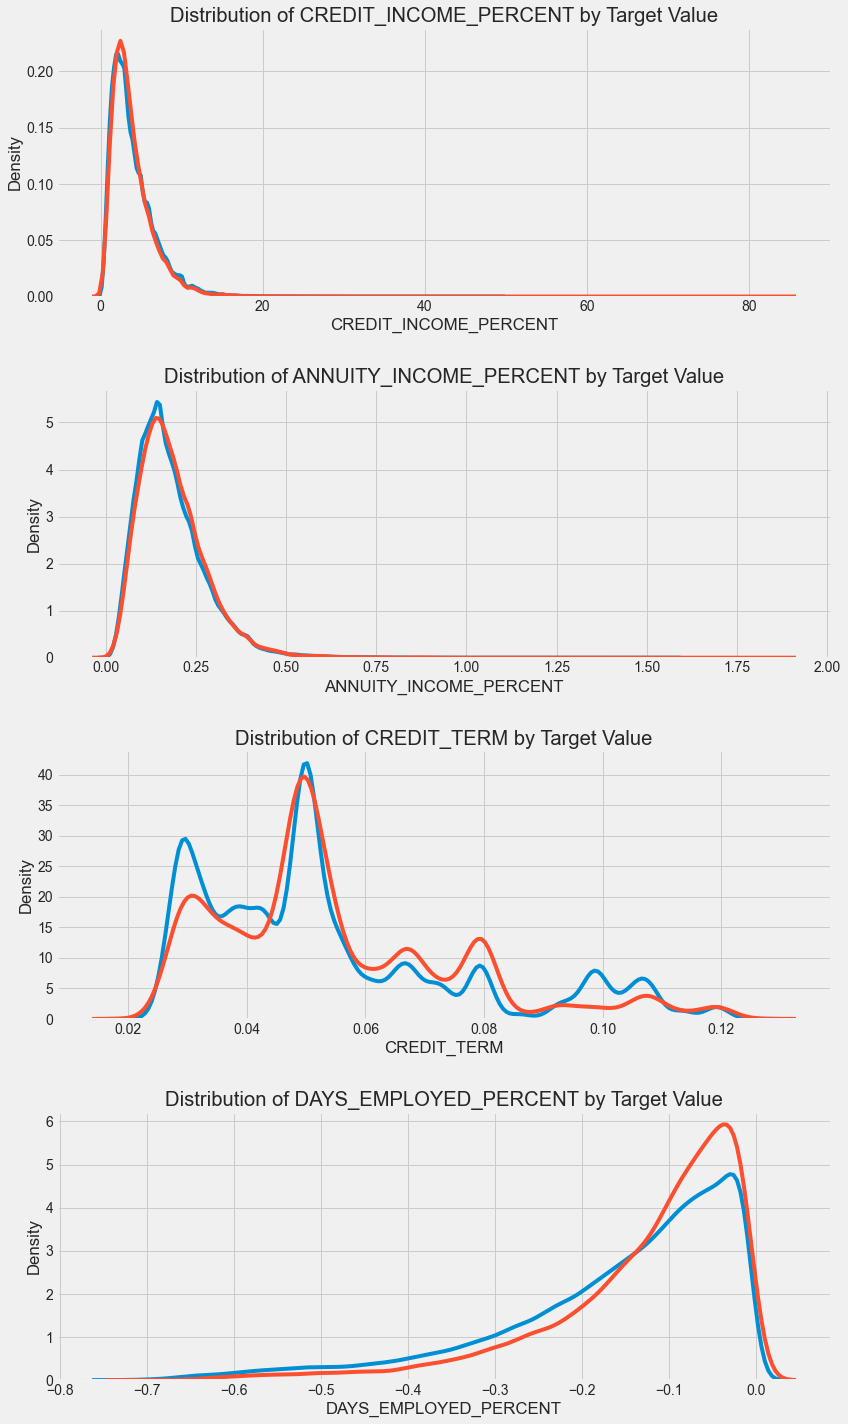

In [175]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0') # TARGET == 0 means the loan was repaid; loc is used to access a group of rows and columns by label(s) or a boolean array, feature is the column name    
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1') # TARGET == 1 means the loan was not repaid
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5) # Adjust the plots

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

In [176]:
# Count NaNs in each dataset before imputation
nan_counts_train = app_train.isnull().sum()
nan_counts_train_poly = app_train_poly.isnull().sum()
nan_counts_train_domain = app_train_domain.isnull().sum()
nan_counts_test = app_test.isnull().sum()

# Display the results
print('Number of NaNs in app_train:')
print(nan_counts_train[nan_counts_train > 0])  # Display only columns with NaNs
print('\nNumber of NaNs in app_train_poly:')
print(nan_counts_train_poly[nan_counts_train_poly > 0])  # Display only columns with NaNs
print('\nNumber of NaNs in app_train_domain:')
print(nan_counts_train_domain[nan_counts_train_domain > 0])  # Display only columns with NaNs
print('\nNumber of NaNs in app_test:')
print(nan_counts_test[nan_counts_test > 0])  # Display only columns with NaNs

Number of NaNs in app_train:
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
DAYS_EMPLOYED                  55374
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 62, dtype: int64

Number of NaNs in app_train_poly:
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
DAYS_EMPLOYED                  55374
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 62, dtype: int64

Number of NaNs in app_train_domain:
AMT_ANNUITY                       1

In [177]:
# imputation
app_train = app_train.fillna(app_train.median()) # Fill in missing values with the median
app_train_poly = app_train_poly.fillna(app_train_poly.median()) # Fill in missing values with the median
app_train_domain = app_train_domain.fillna(app_train_domain.median()) # Fill in missing values with the median
app_test_domain = app_test_domain.fillna(app_test.median()) # Fill in missing values with the median allowing that train and test dataframes are treated the same

In [178]:
# Count NaNs in each dataset after imputation
nan_counts_train_after = app_train.isnull().sum()
nan_counts_train_poly_after = app_train_poly.isnull().sum()
nan_counts_train_domain_after = app_train_domain.isnull().sum()
nan_counts_test_domain_after = app_test_domain.isnull().sum()

# Display the results after imputation
print('Number of NaNs in app_train after imputation:')
print(nan_counts_train_after[nan_counts_train_after > 0])  # Should be empty
print('\nNumber of NaNs in app_train_poly after imputation:')
print(nan_counts_train_poly_after[nan_counts_train_poly_after > 0])  # Should be empty
print('\nNumber of NaNs in app_train_domain after imputation:')
print(nan_counts_train_domain_after[nan_counts_train_domain_after > 0])  # Should be empty
print('\nNumber of NaNs in app_test_domain after imputation:')
print(nan_counts_test_domain_after[nan_counts_test_domain_after > 0])  # Should be empty

Number of NaNs in app_train after imputation:
Series([], dtype: int64)

Number of NaNs in app_train_poly after imputation:
Series([], dtype: int64)

Number of NaNs in app_train_domain after imputation:
Series([], dtype: int64)

Number of NaNs in app_test_domain after imputation:
TARGET                    48744
ANNUITY_INCOME_PERCENT       24
CREDIT_TERM                  24
DAYS_EMPLOYED_PERCENT      9274
dtype: int64


#### Interpretation : The presence of NaNs in the TARGET column of the app_test dataset is normal and expected. This is because the TARGET column represents the target variable (label) that we are trying to predict, and in a typical scenario, the test dataset does not have target values, as these are what we aim to predict.

In [179]:
app_train_poly = app_train_poly.assign(TARGET=app_train['TARGET']) # Add the target back in for the train_poly dataset

In [180]:
# Save the modified dataframes so we don't have to run this notebook every time.
# Don't save test dataframes because there isn't labels for them, 
# We will use the train sets as the whole dataset.

save_dataframes = True # Set this to True to save the dataframes

if save_dataframes: # Save the dataframes to disk
    app_train.to_csv(os.path.join(data_folder, 'app.csv'), index=False) # Save the original data
    app_train_poly.to_csv(os.path.join(data_folder, 'app_poly.csv'), index=False) # Save the polynomial features
    app_train_domain.to_csv(os.path.join(data_folder, 'app_train_domain.csv'), index=False) # Save the domain features
    print("Dataframes saved successfully.")

Dataframes saved successfully.


## Implementing and Evaluating Business-Centric Models for Credit Scoring with Class Imbalance Techniques and Custom Metrics

### Splitting DataFrames into Train/Test Sets on app_train, app_train_poly, and app_train_domain for determining the best model with class imbalance techniques   

In [181]:
from sklearn.model_selection import train_test_split # Import train_test_split function used to split data

# Function to split data
def split_data(df):
    X = df.drop(columns=['TARGET']) # Drop the target variable
    y = df['TARGET'] # Set the target variable
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Split the data into train and test sets with stratification; stratification is used to ensure that the proportion of the target variable is the same in both sets; test_size is used to set the proportion of the test set i.e. 0.2 means 20% of the data is used for testing. random_state is used to set the seed for the random number generator to ensure reproducibility and stratify is used to ensure that the proportion of the target variable is the same in both sets

# Split each DataFrame
X_train_app, X_test_app, y_train_app, y_test_app = split_data(app_train) # Split the original data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = split_data(app_train_poly) # Split the polynomial features data
X_train_domain, X_test_domain, y_train_domain, y_test_domain = split_data(app_train_domain) # Split the domain features data


### Applying Class Imbalance Techniques and Training Models

#### Solutions
- Under-sampling: Reduce the number of clients in the majority class to balance the classes. This can lead to a loss of information.
- Over-sampling: Increase the number of clients in the minority class by duplicating examples or creating synthetic examples (e.g., using the SMOTE method).
- Using Penalization Techniques: Use algorithms that take class imbalance into account, such as weighted decision trees or weighted versions of logistic regression.
- Weighted Logistic Regression: How it works: In logistic regression, each class can be assigned a weight that reflects its importance. The algorithm adjusts the cost function to penalize misclassifications of the minority class more heavily. Effect: This makes the model more sensitive to the minority class, improving recall for the minority class at the potential expense of precision.

- Weighted Decision Trees: How it works: Similar to logistic regression, decision trees can be adjusted to take class imbalance into account by weighting the classes. This affects how the tree splits the nodes, focusing more on correctly classifying the minority class. Effect: This helps the decision tree to make splits that are more balanced in terms of class representation, often improving performance on the minority class.
    
- Penalization techniques are often preferred when you want to maintain the integrity of the original dataset and directly incorporate class imbalance into the model's learning process.

### Presentation of SKLEARN - How to Use Scikit-Learn (sklearn) for Supervised Learning

Scikit-Learn (sklearn) is a powerful Python library for machine learning. Here is a simple workflow for using sklearn to train and evaluate a supervised learning model:

1. **Select an Estimator and Specify its Hyperparameters**:
   - Choose the appropriate model (estimator) for your task and define its hyperparameters.
   - Example:
     ```python
     from sklearn.linear_model import LinearRegression
     model = LinearRegression()  # Specify hyperparameters if needed
     ```

2. **Train the Model on the Data (X, y)**:
   - Use the `.fit()` method to train the model on the training data.
   - `X` represents the input features and `y` represents the target variable.
   - Example:
     ```python
     model.fit(X_train, y_train)
     ```

3. **Evaluate the Model**:
   - Use the `.score()` method to evaluate the model's performance on the test data.
   - The `.score()` method returns the coefficient of determination \( R^2 \) by default for regression models.
   - Example:
     ```python
     score = model.score(X_test, y_test)
     print(f'Model Score: {score}')
     ```

4. **Use the Model to Make Predictions**:
   - Use the `.predict()` method to make predictions on new data.
   - Example:
     ```python
     predictions = model.predict(X_new)
     ```

### Summary

1. **Selecting an Estimator**:
   - Choose the right model for your task and initialize it with the necessary hyperparameters.
   - Example: `model = LinearRegression()`

2. **Training the Model**:
   - Train the model using your training data.
   - Example: `model.fit(X_train, y_train)`

3. **Evaluating the Model**:
   - Evaluate the model using test data to check its performance.
   - Example: `model.score(X_test, y_test)`

4. **Making Predictions**:
   - Use the trained model to make predictions on new or unseen data.
   - Example: `model.predict(X_new)`

This simple and structured approach makes sklearn an easy and efficient tool for building and deploying machine learning models.

#### Evaluating Class Imbalance Techniques with Cost Metric  10 * False Negatives + False Positives and 3 techniques: Under-sampling, Over-sampling, and Class Weighting

##### Explanation of "Cost Metric 10 * False Negatives + False Positives"

The cost metric `10 * False Negatives + False Positives` is a custom evaluation metric designed to prioritize the correct prediction of one class over another, specifically in the context of imbalanced datasets like credit scoring. In this metric:

- **False Negatives (FN)**: Instances where the model incorrectly predicts a defaulter as a non-defaulter.
- **False Positives (FP)**: Instances where the model incorrectly predicts a non-defaulter as a defaulter.

### Why This Metric?

In credit scoring, incorrectly predicting a defaulter as a non-defaulter (false negative) is more costly because it means giving credit to someone who may not repay. This metric penalizes false negatives more heavily to reflect their higher cost.

### Example

Imagine you have a dataset with 100 credit applicants:
- **80 non-defaulters** (majority class)
- **20 defaulters** (minority class)

A model makes the following predictions on a test set:
- **5 false negatives**: 5 defaulters were incorrectly predicted as non-defaulters.
- **3 false positives**: 3 non-defaulters were incorrectly predicted as defaulters.

### Calculation Using the Cost Metric (example)

1. **Formula**: 
   - Cost Metric = 10 * False Negatives + False Positives

2. **Values**:
   - False Negatives = 5
   - False Positives = 3

3. **Calculation**:
   - Cost Metric = 10 * 5 + 3
   - Cost Metric = 50 + 3
   - Cost Metric = 53

### Summary

The cost metric, calculated as 10 times the number of false negatives plus the number of false positives, gives a total cost of 53 for the given predictions. This emphasizes the importance of minimizing false negatives in the model to avoid giving credit to potential defaulters.

### Interpretation

- **High Cost**: A high cost indicates poor performance in correctly predicting defaulters (high false negatives).
- **Objective**: The goal is to minimize this cost metric, emphasizing the reduction of false negatives to avoid giving credit to potential defaulters.

### Summary

The custom cost metric helps ensure that the model pays more attention to correctly predicting defaulters by penalizing false negatives more heavily than false positives. This approach aligns with the business objective of minimizing the risk of granting credit to those who are likely to default.

In [182]:
from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler used for under-sampling is selected as the technique
from imblearn.over_sampling import SMOTE # Import SMOTE used for over-sampling is selected as the technique
from sklearn.linear_model import LogisticRegression # Import Logistic Regression is selected as estimator
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier is selected as estimator

# Custom cost metric function
# The cost metric is defined as 10 * False Negatives + False Positives means that we are penalizing false negatives more than false positives
# In the context of credit scoring, false negatives (predicting a client will repay when they actually default) are more costly than false positives (predicting a client will default when they actually repay).
def cost_metric(y_true, y_pred):
    false_negatives = ((y_true == 1) & (y_pred == 0)).sum()  # Count the false negatives
    false_positives = ((y_true == 0) & (y_pred == 1)).sum() # Count the false positives
    return 10 * false_negatives + false_positives # Return the cost metric

# Function to evaluate a model with under-sampling, over-sampling, and class weighting
def evaluate_model(X_train, y_train, X_test, y_test):
    # Under-sampling
    under_sampler = RandomUnderSampler(random_state=42) # Create a RandomUnderSampler; random_state is used to ensure reproducibility
    X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train) # Fit method is used to resample the training data
    log_reg_under = LogisticRegression(random_state=42) # Create a Logistic Regression model
    log_reg_under.fit(X_train_under, y_train_under) #  Train the model (X_train_under, y_train_under), fit method is used to train the model 
    y_pred_under = log_reg_under.predict(X_test) # Use the model to make predictions on the test data
    cost_under = cost_metric(y_test, y_pred_under) # Calculate the cost metric
    
    # Over-sampling
    smote = SMOTE(random_state=42) # Create a SMOTE object; random_state is used to ensure reproducibility
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train) # Fit and resample the training data
    log_reg_over = LogisticRegression(random_state=42) # Create a Logistic Regression model
    log_reg_over.fit(X_train_over, y_train_over) # Train the model on the data (X_train_over, y_train_over), fit method is used to train the model
    y_pred_over = log_reg_over.predict(X_test) # Use the model to make predictions on the test data on the test data
    cost_over = cost_metric(y_test, y_pred_over) # Calculate the cost metric
    
    # Class weighting with Logistic Regression
    log_reg = LogisticRegression(class_weight='balanced', random_state=42)  # Create a Logistic Regression model with class weighting
    log_reg.fit(X_train, y_train) # Train the model on the data (X_train, y_train), fit method is used to train the model
    y_pred_log_reg = log_reg.predict(X_test) # Use the model to make predictions on the test data 
    cost_log_reg = cost_metric(y_test, y_pred_log_reg) # Calculate the cost metric
    
    # Class weighting with Decision Tree
    tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42) # Create a Decision Tree model with class weighting
    tree_clf.fit(X_train, y_train) # Train the model on the data (X_train, y_train), fit method is used to train the model
    y_pred_tree = tree_clf.predict(X_test) # use the model to make predictions on the test data
    cost_tree = cost_metric(y_test, y_pred_tree) # Calculate the cost metric
    
    print(f'Under-sampling Cost Metric: {cost_under}')
    print(f'Over-sampling Cost Metric: {cost_over}')
    print(f'Logistic Regression with Class Weight Cost Metric: {cost_log_reg}')
    print(f'Decision Tree with Class Weight Cost Metric: {cost_tree}')

# Evaluate on each dataset
print("Evaluating app_train:")
evaluate_model(X_train_app, y_train_app, X_test_app, y_test_app)
print("\nEvaluating app_train_poly:")
evaluate_model(X_train_poly, y_train_poly, X_test_poly, y_test_poly)
print("\nEvaluating app_train_domain:")
evaluate_model(X_train_domain, y_train_domain, X_test_domain, y_test_domain)


Evaluating app_train:
Under-sampling Cost Metric: 43877
Over-sampling Cost Metric: 43886
Logistic Regression with Class Weight Cost Metric: 43850
Decision Tree with Class Weight Cost Metric: 46273

Evaluating app_train_poly:
Under-sampling Cost Metric: 49650
Over-sampling Cost Metric: 38452
Logistic Regression with Class Weight Cost Metric: 38455
Decision Tree with Class Weight Cost Metric: 46195

Evaluating app_train_domain:
Under-sampling Cost Metric: 43852
Over-sampling Cost Metric: 43914
Logistic Regression with Class Weight Cost Metric: 43884
Decision Tree with Class Weight Cost Metric: 46008


### Interpretation of the Results for Metric Evaluation of Class Imbalance Techniques

The results provide the custom cost metric values for different class imbalance handling techniques (under-sampling, over-sampling, class weighting in logistic regression, and class weighting in decision trees) across three datasets: `app_train`, `app_train_poly`, and `app_train_domain`. The custom cost metric is calculated as `10 * False Negatives + False Positives`.

#### Evaluating `app_train`

- **Under-sampling Cost Metric: 43877**
  - This indicates that the total cost for the under-sampling technique is 43,877. This approach removed samples from the majority class to balance the dataset but resulted in a relatively high cost.

- **Over-sampling Cost Metric: 43886**
  - The cost for the over-sampling technique is 43,886. This approach added synthetic samples to the minority class but resulted in a slightly higher cost compared to under-sampling.

- **Logistic Regression with Class Weight Cost Metric: 43850**
  - The cost for logistic regression with class weighting is 43,850. This approach considers the imbalance by adjusting weights and achieved a relatively low cost among the four methods for `app_train`.

- **Decision Tree with Class Weight Cost Metric: 46273**
  - The cost for the decision tree with class weighting is 46,273. This is the highest cost for this dataset, indicating that the decision tree with class weighting did not perform as well in balancing the class cost.

#### Evaluating `app_train_poly`

- **Under-sampling Cost Metric: 49650**
  - The cost for under-sampling is 49,650. This is quite high, suggesting that under-sampling did not perform well with the polynomial features.

- **Over-sampling Cost Metric: 38452**
  - The cost for over-sampling is 38,452, which is the lowest for `app_train_poly`. This indicates that over-sampling performed well with polynomial features.

- **Logistic Regression with Class Weight Cost Metric: 38455**
  - The cost for logistic regression with class weighting is 38,455, which is very close to the over-sampling technique, indicating good performance.

- **Decision Tree with Class Weight Cost Metric: 46195**
  - The cost for the decision tree with class weighting is 46,195, which is quite high, suggesting that it did not perform well with polynomial features.

#### Evaluating `app_train_domain`

- **Under-sampling Cost Metric: 43852**
  - The cost for under-sampling is 43,852. This indicates a moderate performance with the domain-specific features.

- **Over-sampling Cost Metric: 43914**
  - The cost for over-sampling is 43,914, which is very close to the under-sampling cost, suggesting similar performance.

- **Logistic Regression with Class Weight Cost Metric: 43884**
  - The cost for logistic regression with class weighting is 43,884, the lowest for `app_train_domain`, indicating the best performance among the four methods.

- **Decision Tree with Class Weight Cost Metric: 46008**
  - The cost for the decision tree with class weighting is 46,008, higher than logistic regression but lower than its performance on other datasets.

### Summary

1. **Best Technique for `app_train`**:
   - Logistic Regression with Class Weight achieved the lowest cost metric (43,850).

2. **Best Technique for `app_train_poly`**:
   - Over-sampling achieved the lowest cost metric (38,452), closely followed by Logistic Regression with Class Weight (38,455).

3. **Best Technique for `app_train_domain`**:
   - Logistic Regression with Class Weight achieved the lowest cost metric (43,884).

### Conclusion

- Logistic Regression with Class Weight consistently performed well across all datasets, especially for `app_train` and `app_train_domain`.
- Over-sampling performed best for `app_train_poly`, indicating that adding synthetic samples worked well with the polynomial features.
- Decision Trees with Class Weight had the highest cost metrics, suggesting they were not as effective in this scenario.
- Cost metrics 10 * False Negatives + False Positives will be used in the next steps to evaluate the models with the best performing techniques (next notebook)



### Choosing the Train Dataset for Credit Scoring
- The `app_domain` dataset has a good performance with the cost metric evaluation for class imbalance techniques.
- **DAYS_BIRTH**, **EXT_SOURCE_1**, **EXT_SOURCE_2**, and **EXT_SOURCE_3** have a significant impact on whether a client will repay a loan (the TARGET variable) and are included in the application dataset.
- **CREDIT_INCOME_PERCENT**, **ANNUITY_INCOME_PERCENT**, **CREDIT_TERM**, and **DAYS_EMPLOYED_PERCENT** are domain-specific features that may help predict loan repayment (it is assumed that these features are important based on domain knowledge).
- Therefore, we will use the `app_domain` dataset to train a model to predict whether a client will repay a loan.

### We have now a file related to app_domain in our project, and we will use itin the next notebook

- app_train_domain.csv
